# Insulation & boundaries

In [13]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from cooltools import insulation

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("tutorials rely on cooltools version 0.5.1 or higher,"+
                         "please check your cooltools version and update to the latest")

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


## Calculating genome-wide contact insulation
Here we load the Hi-C data at 1 kbp resolution and calculate insulation score with 4 different window sizes

In [4]:
resolution = 10000  
clr = cooler.Cooler('test.mcool::resolutions/'+str(resolution))
windows = [3*resolution, 5*resolution, 10*resolution, 25*resolution]
insulation_table = insulation(clr, windows, verbose=True)

INFO:root:Processing region chr2
INFO:root:Processing region chr17


In [5]:
first_window_summary =insulation_table.columns[[ str(windows[-1]) in i for i in insulation_table.columns]]
insulation_table[['chrom','start','end','region','is_bad_bin']+list(first_window_summary)].iloc[1000:1005]

,chrom,start,end,region,is_bad_bin,log2_insulation_score_250000,n_valid_pixels_250000,boundary_strength_250000,is_boundary_250000
1000,chr2,10000000,10010000,chr2,False,0.309791,622.0,NaN,False
1001,chr2,10010000,10020000,chr2,False,0.226045,622.0,NaN,False
1002,chr2,10020000,10030000,chr2,False,0.090809,622.0,NaN,False
1003,chr2,10030000,10040000,chr2,False,-0.101091,622.0,NaN,False
1004,chr2,10040000,10050000,chr2,False,-0.342858,622.0,NaN,False


In [6]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [9]:
start, end = (10900000, 11650000)

## Annotated figure

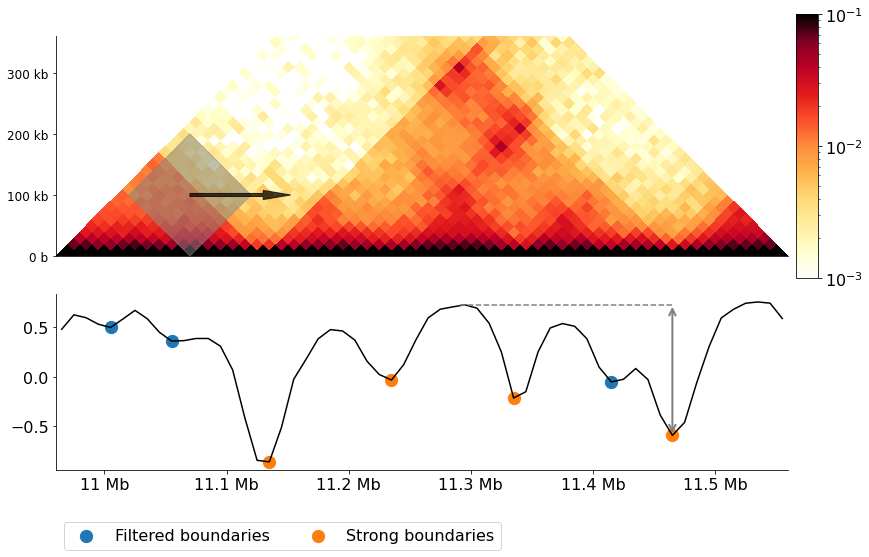

In [15]:
from matplotlib.patches import Path 
from matplotlib import patches 
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
plt.rcParams['font.size'] = 12

start = 10_960_000
end = start+ 20*windows[0]
region = ('chr2', start, end)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clr.matrix(balance=True).fetch(region)



f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=resolution, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 12*windows[0])
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

plt.rcParams['font.size']=16

delta = 100000



diamond_positon = 1_107_0000 
verts = [
   (diamond_positon, 0.),  # left, bottom
   (diamond_positon-delta*.5, delta),  # left, top
   (diamond_positon, delta*2),  # right, top
   (diamond_positon+delta*.5, delta),  # right, bottom
   (diamond_positon, 0.),  # ignored
]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]
path = Path(verts, codes)
patch = patches.PathPatch(path, facecolor='grey',ec='grey',alpha=0.5)#, lw=2)
ax.add_patch(patch)
plt.arrow(diamond_positon, delta, delta*.6, 0,
          width=delta//20,facecolor='black',alpha=0.75, ec='black'
         )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table, region)

ins_ax = divider.append_axes("bottom", size="40%", pad=-1., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1),
            insul_region[f'log2_insulation_score_{windows[0]}'],
            #label=f'Window {windows[0]} bp',
           color='k')

boundaries = insul_region[~np.isnan(insul_region[f'boundary_strength_{windows[0]}'])]
weak_boundaries = boundaries[~boundaries[f'is_boundary_{windows[0]}']]
strong_boundaries = boundaries[boundaries[f'is_boundary_{windows[0]}']]

ins_ax.scatter(weak_boundaries[['start', 'end']].mean(axis=1), 
            weak_boundaries[f'log2_insulation_score_{windows[0]}'], 
            150,alpha=1,
            label='Filtered boundaries')
ins_ax.scatter(strong_boundaries[['start', 'end']].mean(axis=1), 
            strong_boundaries[f'log2_insulation_score_{windows[0]}'], 
               150,alpha=1,
            label='Strong boundaries')

# boundary_num=2
# x_loc = strong_boundaries[['start','end']].mean(axis=1).values[boundary_num]
# y_start =     strong_boundaries[f'log2_insulation_score_{windows[0]}'].values[boundary_num]
# y_end= y_start +strong_boundaries[f'boundary_strength_{windows[0]}'].values[boundary_num]
# plt.annotate(s='', xy=(x_loc,y_start), 
#              xytext=(x_loc, y_end), arrowprops=dict(arrowstyle='<->',lw=2,color='gray'),
#             rotation=90, color='gray')
# #plt.text(x_loc + 3000, y_start+.3,'prominence',rotation=90)
# #plt.plot( [x_loc,x_loc+100000],np.array([1,1])*y_end+.02,'--',color='gray')
# plt.plot( [x_loc,x_loc-175000],np.array([1,1])*y_end,'--',color='gray')

boundary_num=3
x_loc = strong_boundaries[['start','end']].mean(axis=1).values[boundary_num]
y_start =     strong_boundaries[f'log2_insulation_score_{windows[0]}'].values[boundary_num]
y_end= y_start +strong_boundaries[f'boundary_strength_{windows[0]}'].values[boundary_num]
plt.annotate("", xy=(x_loc,y_start), 
             xytext=(x_loc, y_end), arrowprops=dict(arrowstyle='<->',lw=2,color='gray'),
            rotation=90, color='gray')
#plt.text(x_loc + 3000, y_start+.3,'prominence',rotation=90)
#plt.plot( [x_loc,x_loc+100000],np.array([1,1])*y_end+.02,'--',color='gray')
plt.plot( [x_loc,x_loc-175000],np.array([1,1])*y_end,'--',color='gray')


ins_ax.legend(bbox_to_anchor=(0., -.5), loc='lower left', ncol=4);

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ins_ax.spines['right'].set_visible(False)
ins_ax.spines['top'].set_visible(False)

plt.ylim();

plt.savefig("insulation.pdf")